In [2]:
# Our numerical workhorse
import numpy as np
import scipy.special
import pandas as pd

# Import pyplot for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Beeswarm plots
import beeswarm as bs

# emcee for MCMC
import emcee

# corner for pretty pictures
import corner

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [5]:
# let's load the data
df = pd.read_csv('data/hiv_data.csv',comment='#')

In [9]:
# Let's code the functions for V(t,c,delta) and the log posterior

def V (p,V0,t):
    """
    Calculate V(t,c,delta)
    """
    c, delta = p
    return V0*np.exp(-c*t) + \
            c*V0/(c-delta)*(c/(c-delta)*(np.exp(-delta*t)\
            - np.exp(-c*t)) - delta*t*np.exp(-c*t))

def log_post (p,V0,t,Vs):
    """
    Calculate the log posterior
    """
    # Unpack parameters
    c, delta = p
    
    if c == delta:
        return -np.inf
    elif c <= 0 or c > 20:
        return -np.inf
    elif delta <= 0 or delta > 20:
        return -np.inf
    
    # Theoretical spindle length
    V_theor = V(p, V0, t)
    return -len(Vs) / 2 * np.log(np.sum((Vs - V_theor)**2))

def negative_log_post (p,v0,t,Vs):
    """
    Calculate the negative log posterios
    """
    return -log_post(p,v0,t,Vs)

In [7]:
n_dim = 2        # number of parameters in the model (c and delta)
n_walkers = 50   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in

In [8]:
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.exponential(0.1, n_walkers)            # c
p0[:,1] = np.random.uniform(0, 1, n_walkers)             # delta

In [13]:
V0 = df[df['Days after administration']==0.0]['RNA copies per mL'].loc[0]
ts = df['Days after administration'][1:-1]
Vs = df['RNA copies per mL'][1:-1]
args = (V0,ts,Vs)
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, 
                                args=args)

In [14]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [15]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

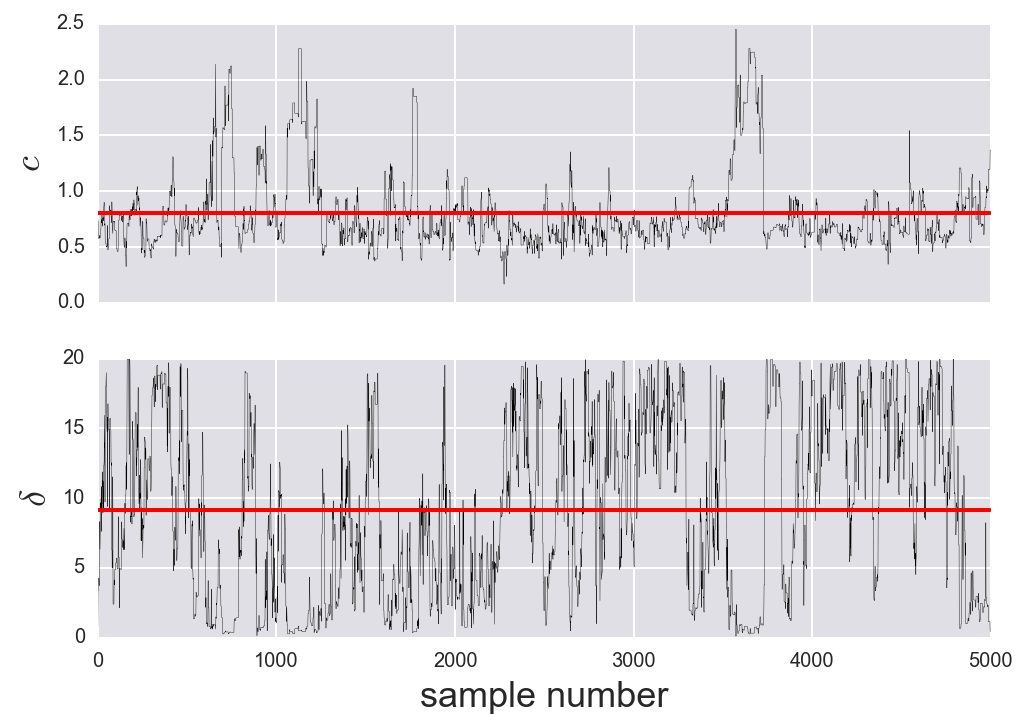

In [26]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i in [0, 1]:
    ax[i].plot(sampler.chain[0,:,i], 'k-', lw=0.2)
    ax[i].plot([0, n_steps-1], 
             [sampler.chain[0,:,i].mean(), sampler.chain[0,:,i].mean()], 'r-')

ax[1].set_xlabel('sample number')
ax[0].set_ylabel('$c$')
ax[1].set_ylabel(r'$\delta$')

/Applications/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Applications/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


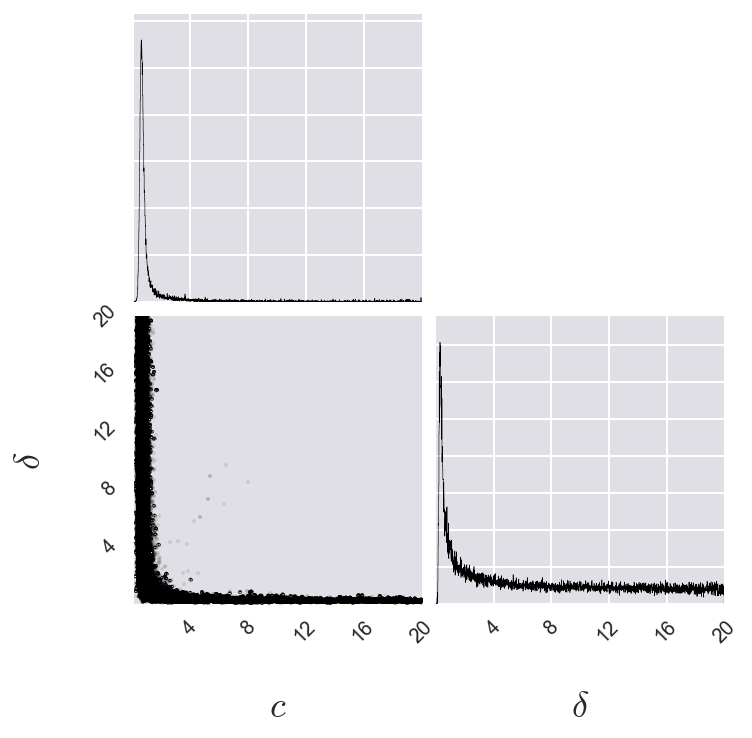

In [27]:
fig = corner.corner(sampler.flatchain, labels=['$c$', r'$\delta$'], bins=2000)
